This post is an exploration of the impact of molecule size on similarity thresholds for some of the fingerprints the RDKit supports. This is inspired by a question Kjell Jorner asked me earlier this week: "Are you aware of any studies (or blog posts) looking at the effect of molecular size on fingerprint similarity?". I'm sure there are sources out there looking at this, but the question fits so well into my ongoing series of [posts about similarity](https://greglandrum.github.io/rdkit-blog/#category=similarity) that I decided to just go ahead and do the analysis.

This post looks at the similarities between random molecules as a function of molecule size. I use a few of the fingerprints available in the RDKit. Along the way there's also some info about the increase in the numbers of bits set in fingerprints as a function of molecule size.

It's not as easy to summarize things here as it was when I looked at [similarity thresholds in general](https://greglandrum.github.io/rdkit-blog/posts/2021-05-18-fingerprint-thresholds1.html), so there's no big table here. The TLDR is that similarities (and thus thresholds) tend to increase with molecular size across all of the fingerprints. There may also be a small increase in the standard deviations of the similarity distributions as the molecules get larger, but since the distributions aren't always gaussian (particularly for tranche 10), this is a weak signal.

It would also be interesting to try and look at the size dependence of the [thresholds for related compounds](https://greglandrum.github.io/rdkit-blog/posts/2021-05-21-similarity-search-thresholds.html), but there it's going to be a bit trickier to divide the results into reasonable tranches.



In [1]:
import gzip
import glob
import pickle
import numpy as np

from rdkit import Chem
from rdkit import rdBase
import rdkit
print(rdkit.__version__)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('tableau-colorblind10')

2025.03.3


I use the number of heavy atoms as a surrogate for molecule size and collect five different tranches:
- 10: 1-9 heavy atoms
- 20: 10-19 heavy atoms
- 30: 20-29 heavy atoms
- 40: 30-39 heavy atoms
- 50: 40-49 heavy atoms

This is the code used to collect tranches which each contain at least 10K molecules from PubChem Compound.

```
import random
fns = list(glob.glob('/fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_*.sdf.gz'))

random.seed(0xa100f)
random.shuffle(fns)

accum = {10:[],20:[],30:[],40:[],50:[]}

def done(accum,tgt=2000):
    for k,v in accum.items():
        if len(v)<tgt:
            return False
    return True

bl = rdBase.BlockLogs()
for fn in fns[:10]:
    print(fn)
    with gzip.open(fn,'rb') as inf:
        suppl = Chem.ForwardSDMolSupplier(inf,sanitize=False,removeHs=True)
        taccum = {10:[],20:[],30:[],40:[],50:[]}
        for i,mol in enumerate(suppl):
            if not mol:
                continue
            if len(Chem.GetMolFrags(mol))>1:
                continue
            nAts = mol.GetNumHeavyAtoms()
            for k in accum:
                if nAts<k:
                    taccum[k].append(mol)
                    break
            if not (i+1)%1000 and done(taccum):
                break
        for k in taccum:
            # take at most 5K/tranche/file
            accum[k].extend(taccum[k][:5000])
        print([len(v) for v in accum.values()])

bl = None       
with gzip.open('./results/pubchem_tranches.pkl.gz','wb+') as outf:
    pickle.dump(accum,outf)
```

In [2]:
with gzip.open('./results/pubchem_tranches.pkl.gz','rb') as inf:
    accum = pickle.load(inf)

In [3]:
print([len(v) for v in accum.values()])


[10502, 50000, 50000, 31458, 28082]


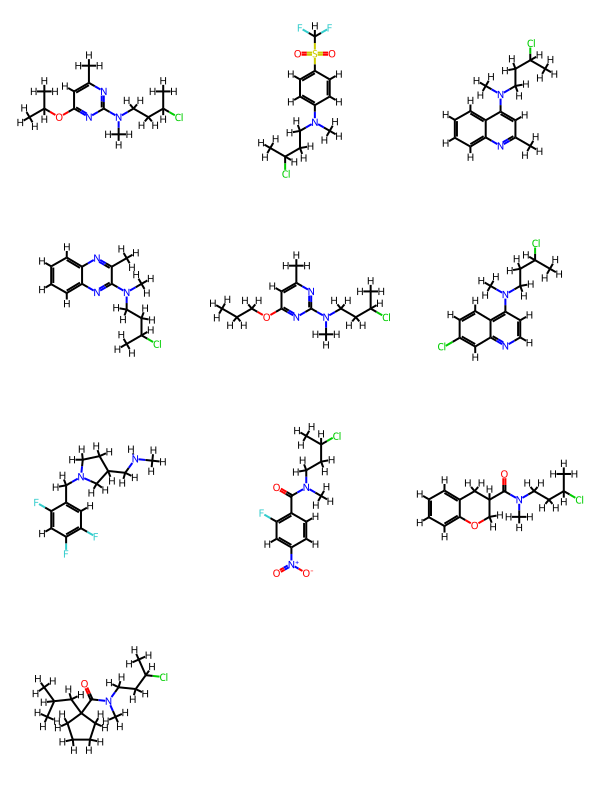

In [4]:
from rdkit.Chem import Draw
Draw.MolsToGridImage(accum[20][:10])

Those have Hs on them, so we'll need to be sure to call `RemoveHs()` below.

Collect similarity values for bit-based and count-based fingerprints using

In [5]:
import random
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from collections import defaultdict

fpgs = {'mfp0':rdFingerprintGenerator.GetMorganGenerator(radius=0),
        'mfp1':rdFingerprintGenerator.GetMorganGenerator(radius=1),
        'mfp2':rdFingerprintGenerator.GetMorganGenerator(radius=2),
        'mfp3':rdFingerprintGenerator.GetMorganGenerator(radius=3),
        'ffp0':rdFingerprintGenerator.GetMorganGenerator(radius=0,atomInvariantsGenerator=rdFingerprintGenerator.GetMorganAtomInvGen()),
        'ffp1':rdFingerprintGenerator.GetMorganGenerator(radius=1,atomInvariantsGenerator=rdFingerprintGenerator.GetMorganAtomInvGen()),
        'ffp2':rdFingerprintGenerator.GetMorganGenerator(radius=2,atomInvariantsGenerator=rdFingerprintGenerator.GetMorganAtomInvGen()),
        'ffp3':rdFingerprintGenerator.GetMorganGenerator(radius=3,atomInvariantsGenerator=rdFingerprintGenerator.GetMorganAtomInvGen()),
        'rdk5':rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5),
        'rdk7':rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7),
        'ap':rdFingerprintGenerator.GetAtomPairGenerator(),
        'tt':rdFingerprintGenerator.GetTopologicalTorsionGenerator(),
       }

bl = rdBase.BlockLogs()

sims_accum = defaultdict(dict)
csims_accum = defaultdict(dict)
bitcounts_accum = defaultdict(dict)
cbitcounts_accum = defaultdict(dict)

for k in accum:
    print(f'Doing {k}')
    fps = defaultdict(list)
    cfps = defaultdict(list)
    nMols = 0
    print('\t generating fps')
    for m in accum[k][:20000]:
        try:
            m = Chem.RemoveHs(m)
        except:
            continue
        nMols += 1
        for nm,fpg in fpgs.items():
            fp = fpg.GetFingerprint(m)
            fps[nm].append(fp)
            cfp = fpg.GetSparseCountFingerprint(m)
            cfps[nm].append(cfp)
    random.seed(0xf00d)
    indices = list(range(nMols))
    indices2 = indices[:]
    pairs = []
    while len(pairs)<50000:
        random.shuffle(indices)
        random.shuffle(indices2)
        pairs.extend(zip(indices,indices2))
    pairs = pairs[:50000]

    print('\t calculating similarities')
    for fpn in fps:
        bitcounts_accum[fpn][k] = [x.GetNumOnBits() for x in fps[fpn]]
        cbitcounts_accum[fpn][k] = [len(x.GetNonzeroElements()) for x in cfps[fpn]]
        
        sims_accum[fpn][k] = [DataStructs.TanimotoSimilarity(fps[fpn][x],fps[fpn][y]) for x,y in pairs if x!=y]
        csims_accum[fpn][k] = [DataStructs.TanimotoSimilarity(cfps[fpn][x],cfps[fpn][y]) for x,y in pairs if x!=y]
                

Doing 10
	 generating fps
	 calculating similarities
Doing 20
	 generating fps
	 calculating similarities
Doing 30
	 generating fps
	 calculating similarities
Doing 40
	 generating fps
	 calculating similarities
Doing 50
	 generating fps
	 calculating similarities


In [6]:
with gzip.open('./results/pubchem_tranches_accum.pkl.gz','wb+') as outf:
    pickle.dump((sims_accum,csims_accum,bitcounts_accum,cbitcounts_accum),outf)

# Similarity stats

Let's start by looking at the quantile values for the various molecule sizes.

In [7]:
for fpn in sims_accum:
    print(f'----- {fpn}')
    for k in sims_accum[fpn]:
        qs = np.quantile(sims_accum[fpn][k],(.7,.8,.9,.95,.99))
        print(k,qs)

----- mfp0
10 [0.2        0.25       0.33333333 0.4        0.55555556]
20 [0.36363636 0.41666667 0.5        0.54545455 0.66666667]
30 [0.41666667 0.46153846 0.53846154 0.6        0.72727273]
40 [0.5        0.53333333 0.6        0.66666667 0.76923077]
50 [0.52631579 0.5625     0.625      0.6875     0.78571429]
----- mfp1
10 [0.08333333 0.11111111 0.15       0.1875     0.26666667]
20 [0.16216216 0.18604651 0.22222222 0.25806452 0.35294118]
30 [0.1875     0.21212121 0.25       0.29411765 0.40912587]
40 [0.21212121 0.23333333 0.26666667 0.3        0.4       ]
50 [0.21126761 0.23188406 0.265625   0.3        0.45767458]
----- mfp2
10 [0.06060606 0.08       0.10810811 0.13333333 0.19230769]
20 [0.10769231 0.12307692 0.14705882 0.16949153 0.24137931]
30 [0.12       0.13513514 0.16049383 0.18666667 0.26229508]
40 [0.13274336 0.14583333 0.16666667 0.18811881 0.26436782]
50 [0.1328125  0.14634146 0.16806723 0.192      0.32352941]
----- mfp3
10 [0.05555556 0.07142857 0.09756098 0.12121212 0.173913

In [8]:
for fpn in csims_accum:
    print(f'----- {fpn}')
    for k in csims_accum[fpn]:
        qs = np.quantile(csims_accum[fpn][k],(.7,.8,.9,.95,.99))
        print(k,qs)

----- mfp0
10 [0.14285714 0.2        0.28571429 0.33333333 0.45454545]
20 [0.31818182 0.36       0.42307692 0.47826087 0.59090909]
30 [0.4        0.44117647 0.5        0.54545455 0.65625   ]
40 [0.46666667 0.50980392 0.55813953 0.6        0.69047619]
50 [0.47368421 0.51724138 0.57142857 0.61818182 0.72340426]
----- mfp1
10 [0.06666667 0.09677419 0.13333333 0.17700535 0.27272727]
20 [0.17647059 0.20634921 0.24528302 0.28301887 0.37254902]
30 [0.23595506 0.26760563 0.31147541 0.35064935 0.44615385]
40 [0.28       0.30769231 0.34736842 0.38461538 0.47368421]
50 [0.29230769 0.32258065 0.36363636 0.40322581 0.51851852]
----- mfp2
10 [0.05263158 0.07317073 0.1025641  0.13157895 0.19444444]
20 [0.12195122 0.14117647 0.17045455 0.19753086 0.27058824]
30 [0.16129032 0.18181818 0.21282506 0.24137931 0.31461298]
40 [0.18987342 0.20886076 0.2384106  0.26712329 0.34210526]
50 [0.2        0.22105263 0.25252525 0.28249816 0.3908046 ]
----- mfp3
10 [0.04878049 0.06666667 0.09375    0.11904762 0.176470

Calculate means and std devs. Note that some of these distributions, particularly those for tranche 10, are not even remotely gaussian, so these values shouldn't be taken overly seriously

In [9]:
print('bit-based')
print(f' fp  \t   10          20          30          40          50')
for fpn in sims_accum:
    means = [np.mean(vs) for vs in sims_accum[fpn].values()]
    stds = [np.std(vs) for vs in sims_accum[fpn].values()]
    blocks = [f'{x:.2f}({y:.2f})' for x,y in zip(means,stds)]
    print(f'{fpn:4s} \t{"  ".join(blocks)}')
    
    
#     for k in sims_accum[fpn]:
#         vs = sims_accum[fpn][k]
#         print(f'{k}:\t{np.mean(vs):.2f}({np.std(vs):.2f})')

bit-based
 fp  	   10          20          30          40          50
mfp0 	0.14(0.13)  0.30(0.14)  0.36(0.13)  0.43(0.13)  0.44(0.15)
mfp1 	0.06(0.06)  0.13(0.07)  0.16(0.07)  0.19(0.07)  0.19(0.08)
mfp2 	0.05(0.05)  0.09(0.05)  0.11(0.05)  0.12(0.05)  0.12(0.05)
mfp3 	0.04(0.04)  0.07(0.04)  0.08(0.04)  0.09(0.03)  0.09(0.04)
ffp0 	0.21(0.16)  0.41(0.15)  0.45(0.14)  0.53(0.14)  0.54(0.16)
ffp1 	0.09(0.07)  0.17(0.07)  0.19(0.07)  0.22(0.07)  0.22(0.08)
ffp2 	0.06(0.05)  0.11(0.05)  0.12(0.05)  0.13(0.05)  0.13(0.05)
ffp3 	0.06(0.05)  0.09(0.04)  0.09(0.03)  0.10(0.03)  0.10(0.04)
rdk5 	0.06(0.07)  0.12(0.07)  0.16(0.07)  0.20(0.07)  0.22(0.09)
rdk7 	0.05(0.05)  0.14(0.06)  0.23(0.08)  0.36(0.10)  0.43(0.13)
ap   	0.05(0.06)  0.15(0.07)  0.22(0.07)  0.31(0.07)  0.36(0.08)
tt   	0.01(0.08)  0.05(0.05)  0.09(0.06)  0.12(0.07)  0.13(0.08)


In [10]:
print('count-based')
print(f' fp  \t   10          20          30          40          50')
for fpn in csims_accum:
    means = [np.mean(vs) for vs in csims_accum[fpn].values()]
    stds = [np.std(vs) for vs in csims_accum[fpn].values()]
    blocks = [f'{x:.2f}({y:.2f})' for x,y in zip(means,stds)]
    print(f'{fpn:4s} \t{"  ".join(blocks)}')

count-based
 fp  	   10          20          30          40          50
mfp0 	0.11(0.12)  0.25(0.13)  0.33(0.14)  0.39(0.13)  0.39(0.15)
mfp1 	0.06(0.06)  0.14(0.08)  0.19(0.09)  0.24(0.09)  0.24(0.10)
mfp2 	0.04(0.05)  0.10(0.06)  0.13(0.06)  0.16(0.06)  0.17(0.08)
mfp3 	0.04(0.04)  0.08(0.05)  0.11(0.05)  0.13(0.05)  0.13(0.06)
ffp0 	0.16(0.13)  0.33(0.14)  0.39(0.14)  0.46(0.14)  0.46(0.15)
ffp1 	0.08(0.07)  0.18(0.08)  0.23(0.09)  0.28(0.09)  0.28(0.11)
ffp2 	0.06(0.05)  0.12(0.06)  0.16(0.06)  0.19(0.07)  0.19(0.08)
ffp3 	0.05(0.05)  0.10(0.05)  0.12(0.05)  0.14(0.05)  0.15(0.06)
rdk5 	0.04(0.06)  0.08(0.08)  0.11(0.08)  0.13(0.08)  0.14(0.09)
rdk7 	0.03(0.05)  0.04(0.05)  0.05(0.05)  0.06(0.05)  0.06(0.07)
ap   	0.03(0.05)  0.09(0.06)  0.14(0.07)  0.18(0.07)  0.19(0.09)
tt   	0.00(0.02)  0.03(0.05)  0.06(0.06)  0.09(0.07)  0.10(0.08)


In [88]:
def dfilter(accum,fthresh=0.005,nbins=20):
    '''
    function to remove extremely small values from the upper values of a data set before doing a histogram 
    '''
    res = []
    for v in accum.values():
        counts,edges = np.histogram(v,bins=nbins)
        tot = np.sum(counts)
        thresh = fthresh*tot
        edge = edges[-1]
        for i,cnt in enumerate(reversed(counts)):
            if cnt>thresh:
                break
            edge = edges[-1*(i+1)]
        res.append([x for x in v if x<edge])
    return res

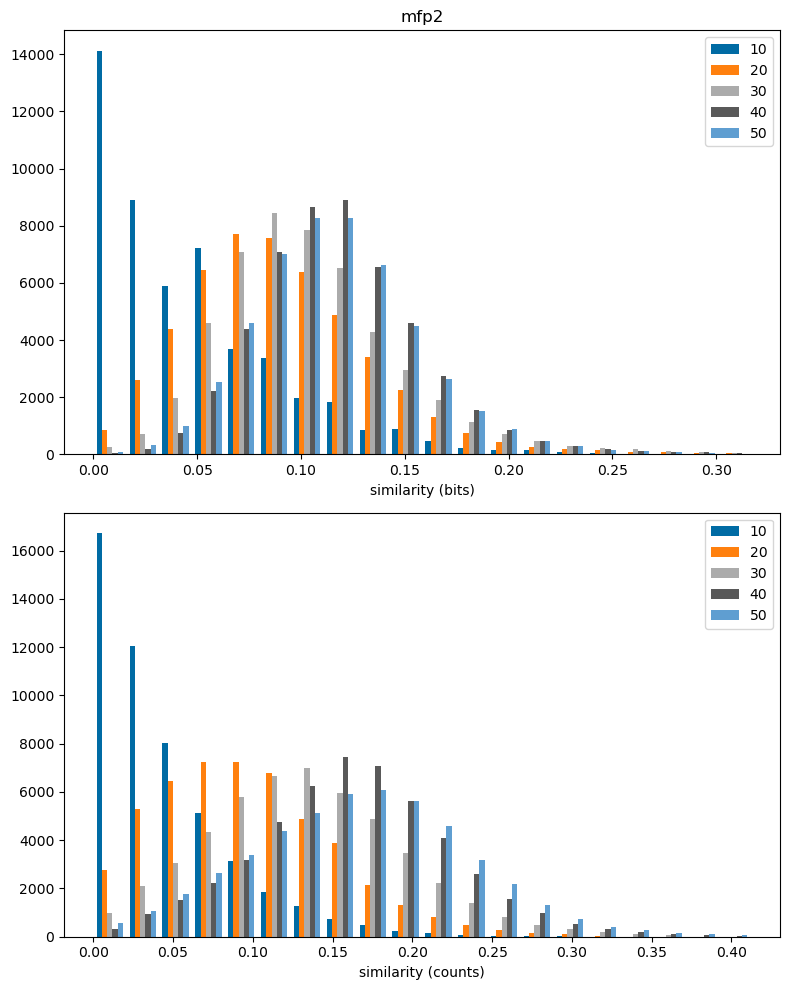

In [89]:
fpn = 'mfp2'
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.hist(dfilter(sims_accum[fpn]),bins=20,label=sims_accum[fpn].keys());
plt.legend();
plt.xlabel('similarity (bits)')
plt.title(fpn);
plt.subplot(2,1,2)
plt.hist(dfilter(csims_accum[fpn]),bins=20,label=csims_accum[fpn].keys());
plt.xlabel('similarity (counts)')
plt.legend();
plt.tight_layout()

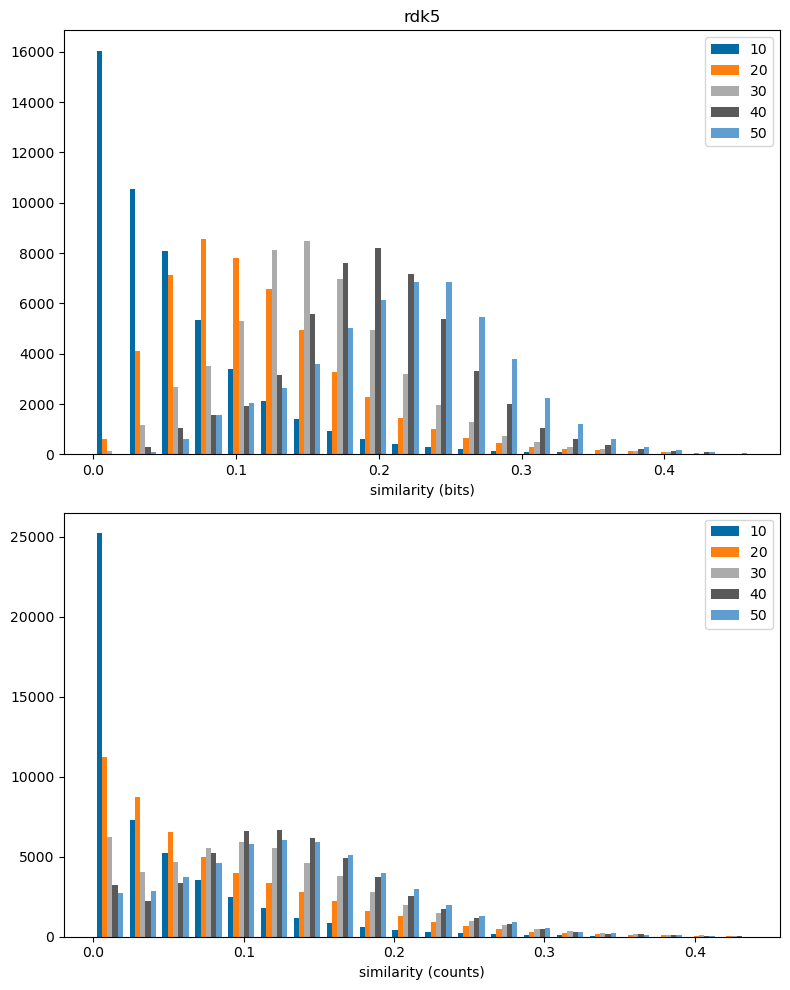

In [90]:
fpn = 'rdk5'
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.hist(dfilter(sims_accum[fpn]),bins=20,label=sims_accum[fpn].keys());
plt.legend();
plt.xlabel('similarity (bits)')
plt.title(fpn);
plt.subplot(2,1,2)
plt.hist(dfilter(csims_accum[fpn]),bins=20,label=csims_accum[fpn].keys());
plt.xlabel('similarity (counts)')
plt.legend();
plt.tight_layout()

# Bit counts

As you'd expect, smaller molecules set way fewer bits:

In [91]:
print('bit-based')
print(f' fp  \t     10              20              30              40              50')
for fpn in csims_accum:
    means = [np.mean(vs) for vs in bitcounts_accum[fpn].values()]
    stds = [np.std(vs) for vs in bitcounts_accum[fpn].values()]
    blocks = [f'{x:6.1f}({y:6.1f})' for x,y in zip(means,stds)]
    print(f'{fpn:4s} \t{"  ".join(blocks)}')

bit-based
 fp  	     10              20              30              40              50
mfp0 	   5.3(   1.6)     8.7(   1.9)    10.0(   2.0)    11.4(   2.1)    11.8(   2.6)
mfp1 	  11.9(   3.5)    22.1(   4.2)    27.5(   5.0)    34.5(   5.9)    38.1(   8.1)
mfp2 	  16.4(   5.2)    33.6(   6.4)    44.2(   7.5)    57.9(   8.7)    66.3(  12.2)
mfp3 	  18.4(   6.5)    43.1(   8.6)    59.3(  10.2)    79.8(  11.2)    93.4(  15.6)
ffp0 	   5.1(   1.5)     7.5(   1.6)     8.5(   1.7)     9.4(   1.8)     9.6(   2.0)
ffp1 	  11.7(   3.4)    20.7(   3.9)    25.5(   4.5)    31.6(   5.4)    34.8(   7.2)
ffp2 	  16.2(   5.1)    32.2(   6.0)    42.2(   7.0)    54.9(   8.3)    62.9(  11.3)
ffp3 	  18.2(   6.3)    41.6(   8.2)    57.3(   9.7)    76.9(  10.9)    90.0(  14.9)
rdk5 	  64.7(  37.2)   193.7(  74.1)   289.3( 104.2)   411.9( 129.0)   478.9( 161.4)
rdk7 	  95.0(  70.0)   444.3( 206.6)   725.5( 281.7)  1039.6( 314.8)  1220.0( 349.5)
ap   	  26.4(  10.5)   113.6(  30.7)   212.7(  51.9)   372.9( 

In [12]:
print('count-based')
print(f' fp  \t     10              20              30              40              50')
for fpn in csims_accum:
    means = [np.mean(vs) for vs in cbitcounts_accum[fpn].values()]
    stds = [np.std(vs) for vs in cbitcounts_accum[fpn].values()]
    blocks = [f'{x:6.1f}({y:6.1f})' for x,y in zip(means,stds)]
    print(f'{fpn:4s} \t{"  ".join(blocks)}')

count-based
 fp  	     10              20              30              40              50
mfp0 	   5.3(   1.6)     8.8(   1.9)    10.1(   2.0)    11.6(   2.1)    12.1(   2.7)
mfp1 	  12.1(   3.6)    22.3(   4.3)    27.7(   5.0)    34.9(   6.0)    38.7(   8.3)
mfp2 	  16.5(   5.3)    33.9(   6.4)    44.7(   7.7)    58.7(   8.9)    67.5(  12.6)
mfp3 	  18.5(   6.5)    43.6(   8.7)    60.1(  10.5)    81.5(  11.6)    95.7(  16.2)
ffp0 	   5.2(   1.6)     7.7(   1.6)     8.7(   1.7)     9.7(   1.8)    10.0(   2.1)
ffp1 	  11.9(   3.5)    21.1(   3.9)    26.0(   4.6)    32.3(   5.5)    35.6(   7.5)
ffp2 	  16.4(   5.2)    32.6(   6.0)    43.0(   7.2)    56.1(   8.5)    64.4(  11.8)
ffp3 	  18.4(   6.4)    42.3(   8.3)    58.4(  10.0)    78.8(  11.3)    92.5(  15.5)
rdk5 	  66.1(  38.8)   205.3(  82.8)   316.0( 124.2)   468.2( 163.8)   560.4( 216.5)
rdk7 	  98.6(  76.1)   520.7( 284.5)   953.3( 500.9)  1568.9( 709.7)  2064.2( 952.7)
ap   	  20.9(   9.2)    80.2(  25.2)   140.9(  40.7)   239.3

The difference in numbers of bits set between the sparse count-based and bit-based fingerprint is a measure of the number of collisions arising from folding the fingerprint. I've done a [blog post about this](https://greglandrum.github.io/rdkit-blog/posts/2023-01-23-colliding-bits-iii-expanded.html) that showed that collisions tend to increase similarity values.

The results above, unsurprisingly, show that collisions are much more prevalent in larger molecules, where more bits are set. This is particularly true for the RDKit fingerprint, which sets a very large number of bits.

> Note: by default the bit-based versions of the atom pair and topological torsion fingerprints use [count simulation](https://greglandrum.github.io/rdkit-blog/posts/2021-07-06-simulating-counts.html), so features that are present multiple times in a molecule can lead to multiple bits being set in the bit-based fingerprint. This leads to the unusual behavior observed above that there are more bits set in the bit-based fingerprints than the count-based ones, particularly for larger molecules.


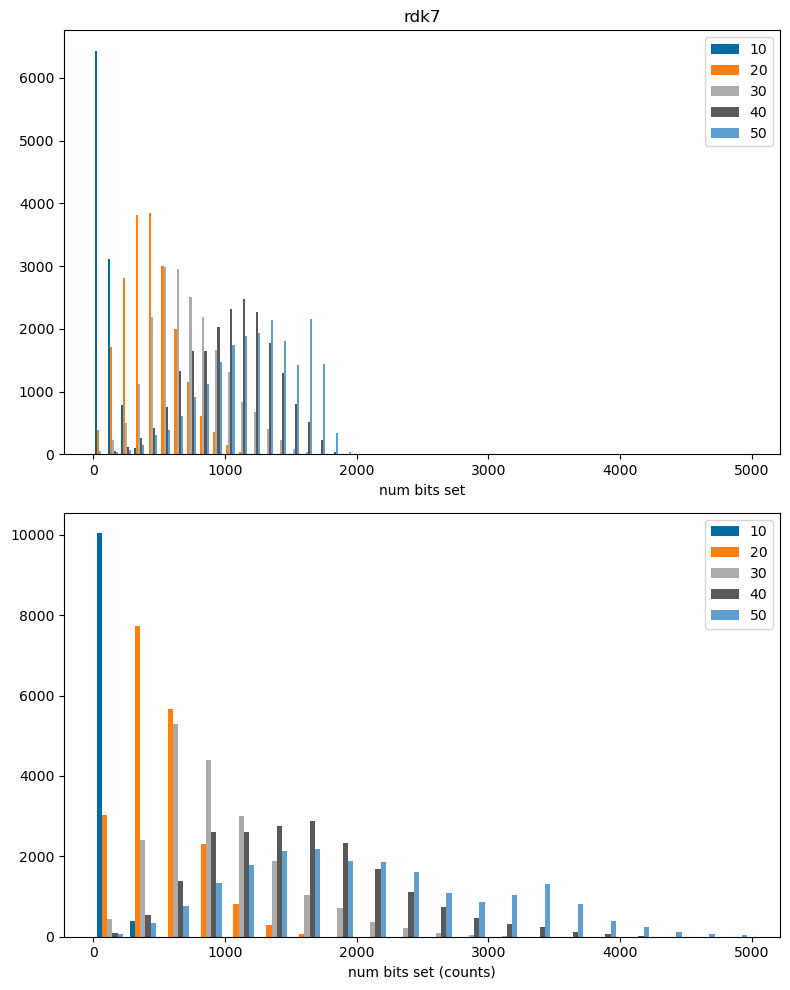

In [99]:
fpn = 'rdk7'
plt.figure(figsize=(8,10))


plt.subplot(2,1,2)
plt.hist(dfilter(cbitcounts_accum[fpn]),bins=20,label=cbitcounts_accum[fpn].keys());
lim = plt.xlim()
plt.xlabel('num bits set (counts)')
#plt.xlim(0,0.5);
plt.legend();

plt.subplot(2,1,1)
plt.hist(dfilter(bitcounts_accum[fpn]),bins=20,label=bitcounts_accum[fpn].keys());
plt.xlim(lim[0],lim[1]);
plt.xlabel('num bits set')
plt.legend();
plt.title(fpn)

plt.tight_layout();


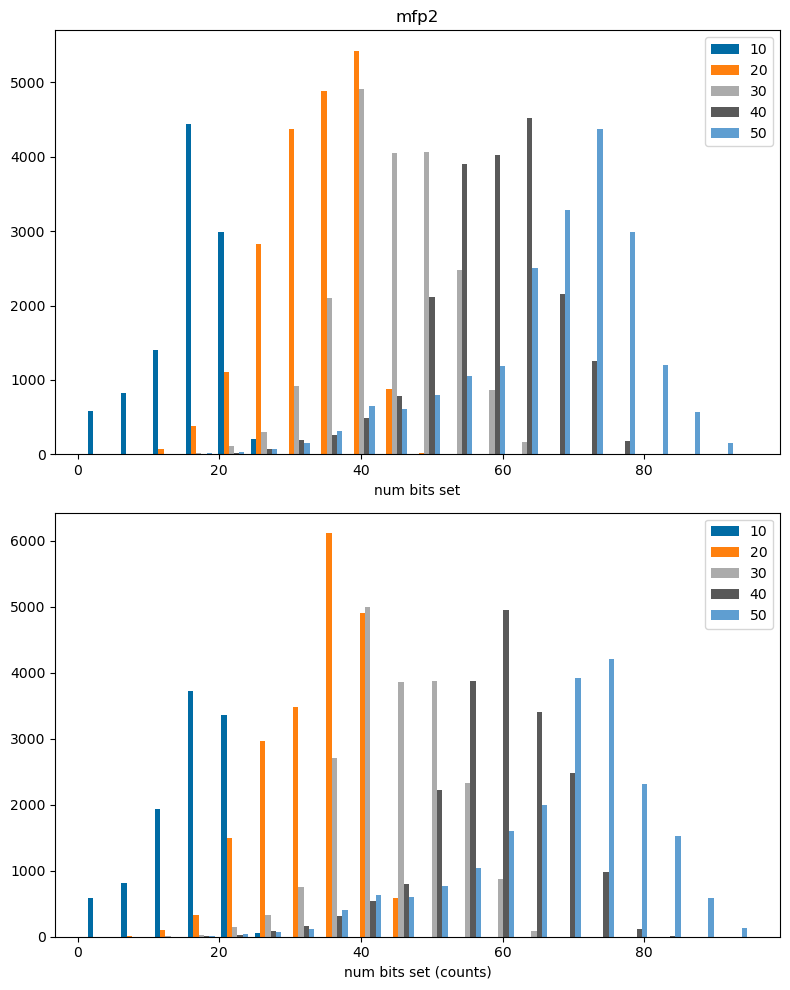

In [100]:
fpn = 'mfp2'
plt.figure(figsize=(8,10))


plt.subplot(2,1,2)
plt.hist(dfilter(cbitcounts_accum[fpn]),bins=20,label=cbitcounts_accum[fpn].keys());
lim = plt.xlim()
plt.xlabel('num bits set (counts)')
#plt.xlim(0,0.5);
plt.legend();

plt.subplot(2,1,1)
plt.hist(dfilter(bitcounts_accum[fpn]),bins=20,label=bitcounts_accum[fpn].keys());
plt.xlim(lim[0],lim[1]);
plt.xlabel('num bits set')
plt.legend();
plt.title(fpn)

plt.tight_layout();


# Collisions

We can directly get stats on the number of collisions:

In [102]:
print('count-based')
print(f' fp  \t     10              20              30              40              50')
for fpn in csims_accum:
    diffs = [np.array(x)-np.array(y) for x,y in zip(cbitcounts_accum[fpn].values(),bitcounts_accum[fpn].values())]
    means = [np.mean(vs) for vs in diffs]
    stds = [np.std(vs) for vs in diffs]
    blocks = [f'{x:6.1f}({y:6.1f})' for x,y in zip(means,stds)]
    print(f'{fpn:4s} \t{"  ".join(blocks)}')

count-based
 fp  	     10              20              30              40              50
mfp0 	   0.1(   0.3)     0.2(   0.4)     0.1(   0.3)     0.2(   0.4)     0.3(   0.5)
mfp1 	   0.1(   0.3)     0.2(   0.4)     0.2(   0.5)     0.4(   0.6)     0.6(   0.7)
mfp2 	   0.1(   0.4)     0.3(   0.6)     0.5(   0.7)     0.9(   0.9)     1.3(   1.1)
mfp3 	   0.2(   0.4)     0.5(   0.7)     0.9(   1.0)     1.6(   1.3)     2.3(   1.6)
ffp0 	   0.1(   0.3)     0.2(   0.4)     0.2(   0.4)     0.3(   0.4)     0.4(   0.5)
ffp1 	   0.2(   0.4)     0.3(   0.5)     0.5(   0.7)     0.7(   0.8)     0.9(   0.8)
ffp2 	   0.2(   0.4)     0.5(   0.6)     0.7(   0.8)     1.2(   1.0)     1.5(   1.2)
ffp3 	   0.2(   0.4)     0.7(   0.8)     1.1(   1.1)     1.9(   1.4)     2.5(   1.6)
rdk5 	   1.4(   2.0)    11.6(   9.6)    26.7(  21.1)    56.2(  36.5)    81.5(  57.0)
rdk7 	   3.6(   7.8)    76.4(  83.1)   227.8( 230.7)   529.3( 410.5)   844.2( 621.1)
ap   	  -5.5(   4.6)   -33.4(  13.1)   -71.8(  23.5)  -133.6

The negative values here for the atom pair and topological torsion fingerprints are due to [count simulation](https://greglandrum.github.io/rdkit-blog/posts/2021-07-06-simulating-counts.html): multiple bits can be set for each feature in the molecule.